# **Mini Project: Classification 3 Models & Evaluations for Sample - Superstore**

###Kelompok 3 Artificial Interlligence:
1. Fabio Banyu Cyto (123450104)
2. Gusti Putu Ferazka D. (123450046)
3. Aliya Amara Ananta (123450075)
4. Hafsa Fazila Arradhi	(123450079)

## **Import Library**

In [1]:
#Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
import shap

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
np.random.seed(42)

## **Load & Understanding Dataset**

In [2]:
df = pd.read_csv("/content/Sample - Superstore.csv", encoding='latin1')
df['target'] = (df['Profit'] > 0).astype(int)

df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,target
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,1
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,1
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,1
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,0
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,1


In [3]:
print(df.shape)
df.info()

(9994, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 1

In [4]:
df.isnull().sum()

,0
Row ID,0
Order ID,0
Order Date,0
Ship Date,0
Ship Mode,0
Customer ID,0
Customer Name,0
Segment,0
Country,0
City,0


In [5]:
print("\nDistribusi Target:")
print(df['target'].value_counts())
print(df['target'].value_counts(normalize=True))


Distribusi Target:
target
1    8058
0    1936
Name: count, dtype: int64
target
1    0.806284
0    0.193716
Name: proportion, dtype: float64


## **Exploratory Data Analysis (EDA)**

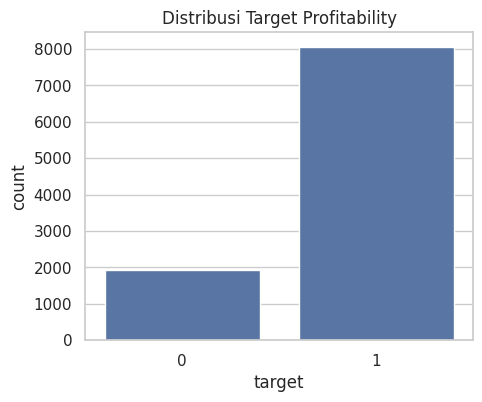

In [6]:
# Target distribution
plt.figure(figsize=(5,4))
sns.countplot(x='target', data=df)
plt.title("Distribusi Target Profitability")
plt.show()

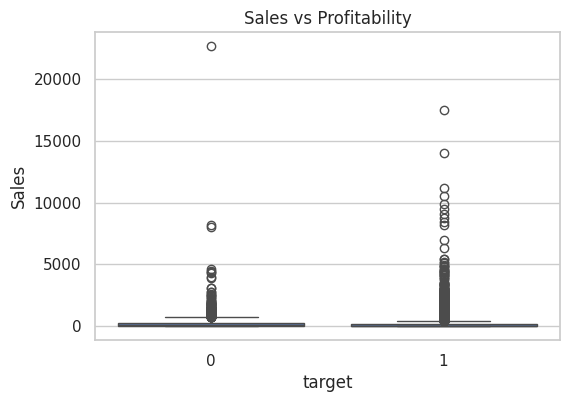

In [7]:
# Profit vs Sales
plt.figure(figsize=(6,4))
sns.boxplot(x='target', y='Sales', data=df)
plt.title("Sales vs Profitability")
plt.show()

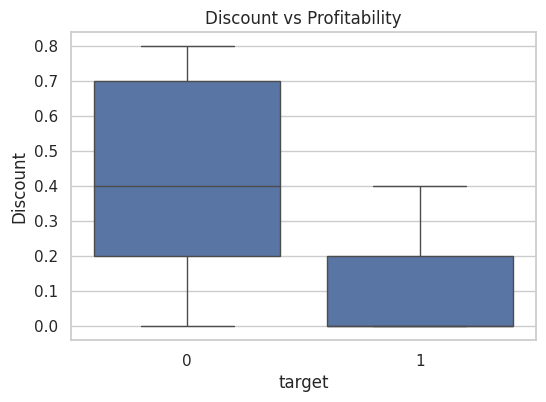

In [8]:
# Profit vs Discount
plt.figure(figsize=(6,4))
sns.boxplot(x='target', y='Discount', data=df)
plt.title("Discount vs Profitability")
plt.show()

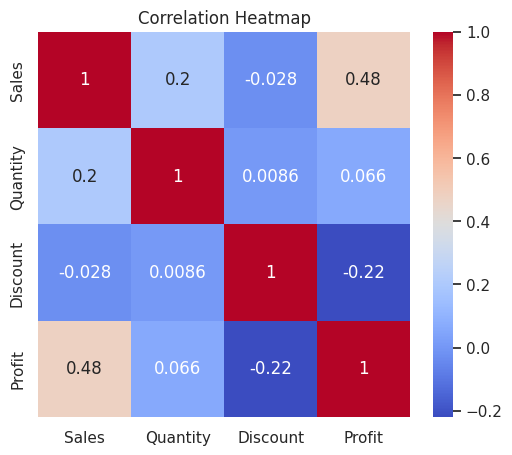

In [9]:
# Correlation (numerical)
plt.figure(figsize=(6,5))
sns.heatmap(
    df[['Sales','Quantity','Discount','Profit']].corr(),
    annot=True, cmap='coolwarm'
)
plt.title("Correlation Heatmap")
plt.show()

## **Data Preprocessing & Feature Engineering**

In [10]:
# Drop kolom ID, tanggal, dan high-cardinality text
df_model = df.drop(columns=[
    'Row ID','Order ID','Customer ID','Customer Name',
    'Order Date','Ship Date','Product Name',
    'Country','State','City','Postal Code', 'Product ID'
])

# One-hot encoding untuk kategori yang relevan
categorical_cols = ['Segment','Region','Category','Sub-Category','Ship Mode']
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

for col in df_model.select_dtypes(include='bool').columns:
    df_model[col] = df_model[col].astype(int)

# Features & target
X = df_model.drop(columns=['Profit','target'])
y = df_model['target']

# Cek terakhir: pastikan SEMUA numerik
print(X.dtypes.value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Scaling KHUSUS Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

int64      27
float64     2
Name: count, dtype: int64


## **Modeling**

In [11]:
#Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:,1]

In [12]:
#Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

In [13]:
#XGBoost
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:,1]

## **Model Evaluation**

In [14]:
#Accuracy, Precision, Recall, F1-Score, ROC
def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"\n{name}")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print("ROC-AUC  :", roc_auc_score(y_true, y_proba))
    print(classification_report(y_true, y_pred))

evaluate_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
evaluate_model("Random Forest", y_test, y_pred_rf, y_proba_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb, y_proba_xgb)


Logistic Regression
Accuracy : 0.9424712356178089
Precision: 0.950632149307646
Recall   : 0.9795285359801489
F1-score : 0.9648640391078521
ROC-AUC  : 0.9817839075153403
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       387
           1       0.95      0.98      0.96      1612

    accuracy                           0.94      1999
   macro avg       0.93      0.88      0.90      1999
weighted avg       0.94      0.94      0.94      1999


Random Forest
Accuracy : 0.9404702351175588
Precision: 0.9327536231884058
Recall   : 0.9981389578163772
F1-score : 0.9643392268504645
ROC-AUC  : 0.9828779310212169
              precision    recall  f1-score   support

           0       0.99      0.70      0.82       387
           1       0.93      1.00      0.96      1612

    accuracy                           0.94      1999
   macro avg       0.96      0.85      0.89      1999
weighted avg       0.94      0.94      0.94      1999


XGBoost
Ac

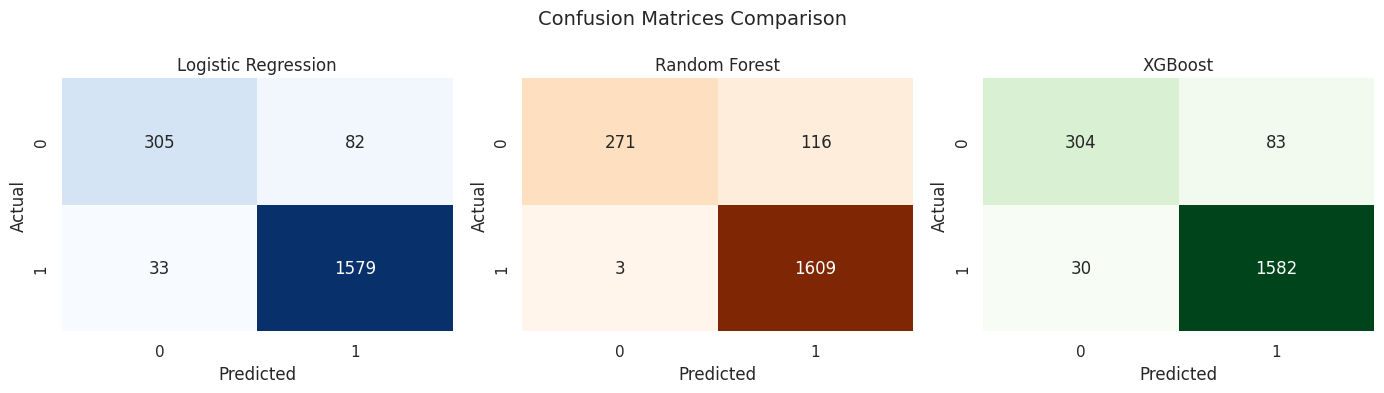

In [15]:
# Confusion Matrices
models = {
    "Logistic Regression": (y_pred_lr, "Blues"),
    "Random Forest": (y_pred_rf, "Oranges"),
    "XGBoost": (y_pred_xgb, "Greens")
}

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (name, (pred, cmap)) in zip(axes, models.items()):
    cm = confusion_matrix(y_test, pred)

    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap=cmap,
        cbar=False,
        ax=ax
    )

    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.suptitle("Confusion Matrices Comparison", fontsize=14)
plt.tight_layout()
plt.show()

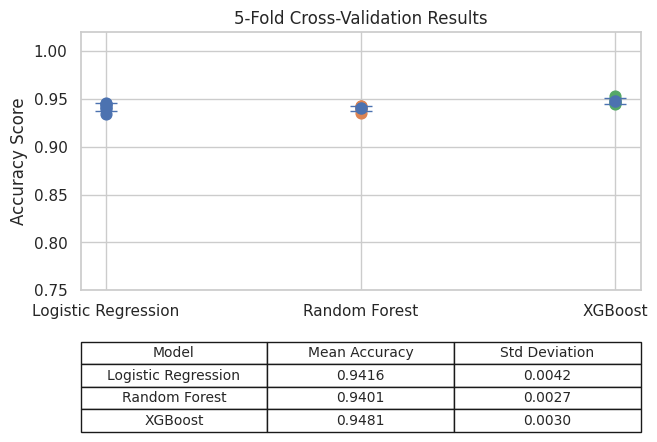

In [16]:
#Cross Validation 5-FOLD: Mean + STD
cv_lr = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='accuracy')
cv_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
cv_xgb = cross_val_score(xgb, X_train, y_train, cv=5, scoring='accuracy')

cv_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Mean Accuracy': [
        cv_lr.mean(),
        cv_rf.mean(),
        cv_xgb.mean()
    ],
    'Std Deviation': [
        cv_lr.std(),
        cv_rf.std(),
        cv_xgb.std()
    ]
})

fig, ax = plt.subplots(figsize=(8,6))
x_pos = np.arange(len(cv_summary))

ax.scatter(
    np.repeat(x_pos[0], len(cv_lr)),
    cv_lr,
    s=60
)
ax.scatter(
    np.repeat(x_pos[1], len(cv_rf)),
    cv_rf,
    s=60
)
ax.scatter(
    np.repeat(x_pos[2], len(cv_xgb)),
    cv_xgb,
    s=60
)

ax.errorbar(
    x_pos,
    cv_summary['Mean Accuracy'],
    yerr=cv_summary['Std Deviation'],
    fmt='o',
    capsize=8,
    markersize=8
)

ax.set_xticks(x_pos)
ax.set_xticklabels(cv_summary['Model'])
ax.set_ylabel("Accuracy Score")
ax.set_title("5-Fold Cross-Validation Results")
ax.set_ylim(0.75, 1.02)

table_data = [
    [
        cv_summary.loc[i, 'Model'],
        f"{cv_summary.loc[i, 'Mean Accuracy']:.4f}",
        f"{cv_summary.loc[i, 'Std Deviation']:.4f}"
    ]
    for i in range(len(cv_summary))
]

table = plt.table(
    cellText=table_data,
    colLabels=['Model', 'Mean Accuracy', 'Std Deviation'],
    cellLoc='center',
    loc='bottom',
    bbox=[0.0, -0.55, 1, 0.35]
)

table.auto_set_font_size(False)
table.set_fontsize(10)
plt.subplots_adjust(left=0.2, bottom=0.45)
plt.show()

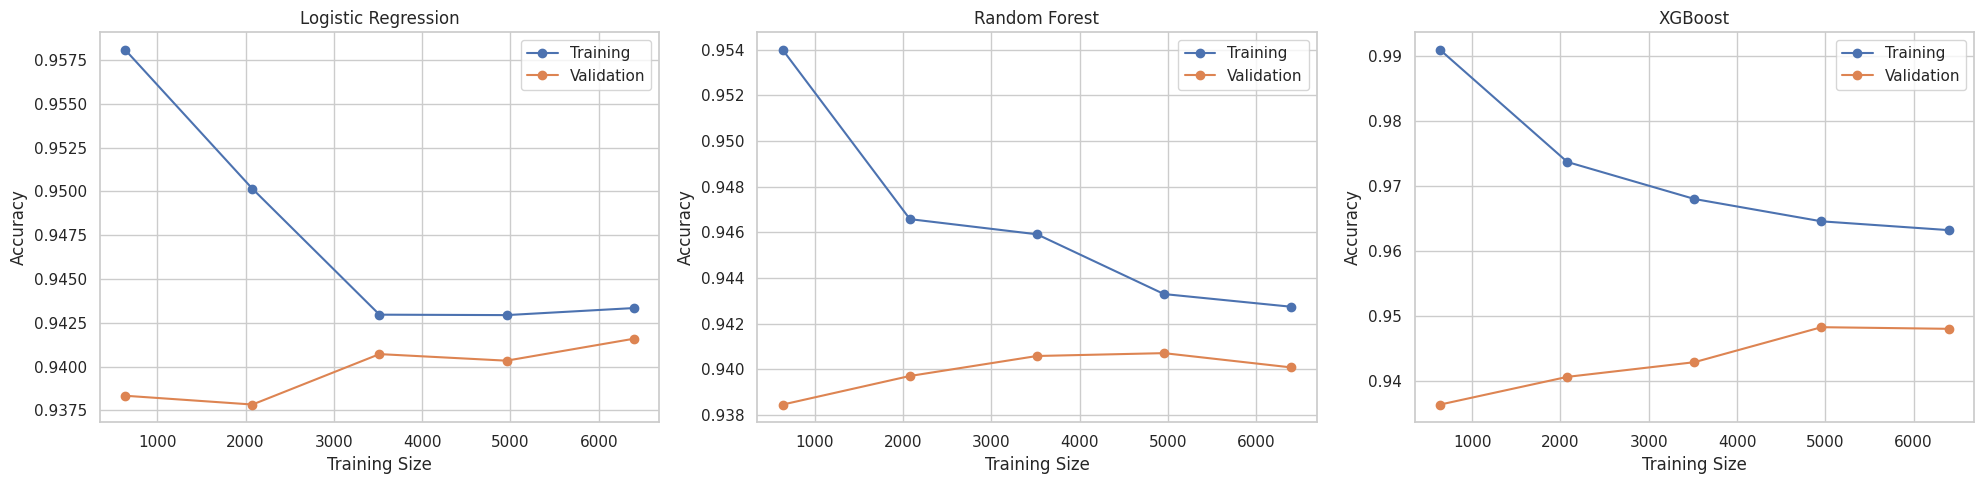

In [17]:
#Learning Curves
def plot_learning_curve(model, X, y, title, ax):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 5)
    )

    ax.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Training')
    ax.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validation')

    ax.set_title(title)
    ax.set_xlabel("Training Size")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(True)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

plot_learning_curve(lr, X_train_scaled, y_train, "Logistic Regression", axes[0])
plot_learning_curve(rf, X_train, y_train, "Random Forest", axes[1])
plot_learning_curve(xgb, X_train, y_train, "XGBoost", axes[2])

plt.tight_layout()
plt.show()

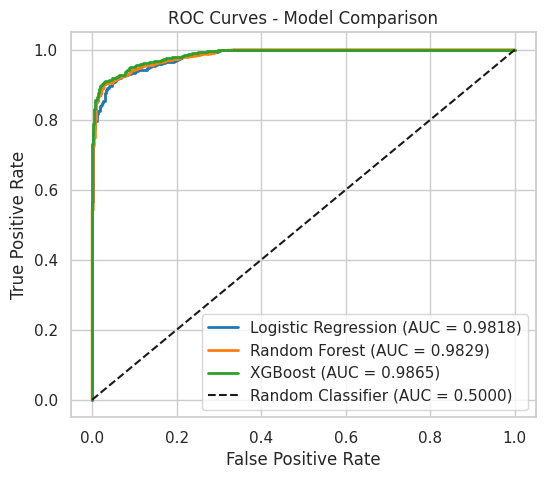

In [18]:
plt.figure(figsize=(6,5))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)
plt.plot(
    fpr_lr, tpr_lr,
    label=f"Logistic Regression (AUC = {auc_lr:.4f})",
    color='tab:blue',
    linewidth=2
)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)
plt.plot(
    fpr_rf, tpr_rf,
    label=f"Random Forest (AUC = {auc_rf:.4f})",
    color='tab:orange',
    linewidth=2
)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)
plt.plot(
    fpr_xgb, tpr_xgb,
    label=f"XGBoost (AUC = {auc_xgb:.4f})",
    color='tab:green',
    linewidth=2
)

# Random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Model Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## **Interpretations**

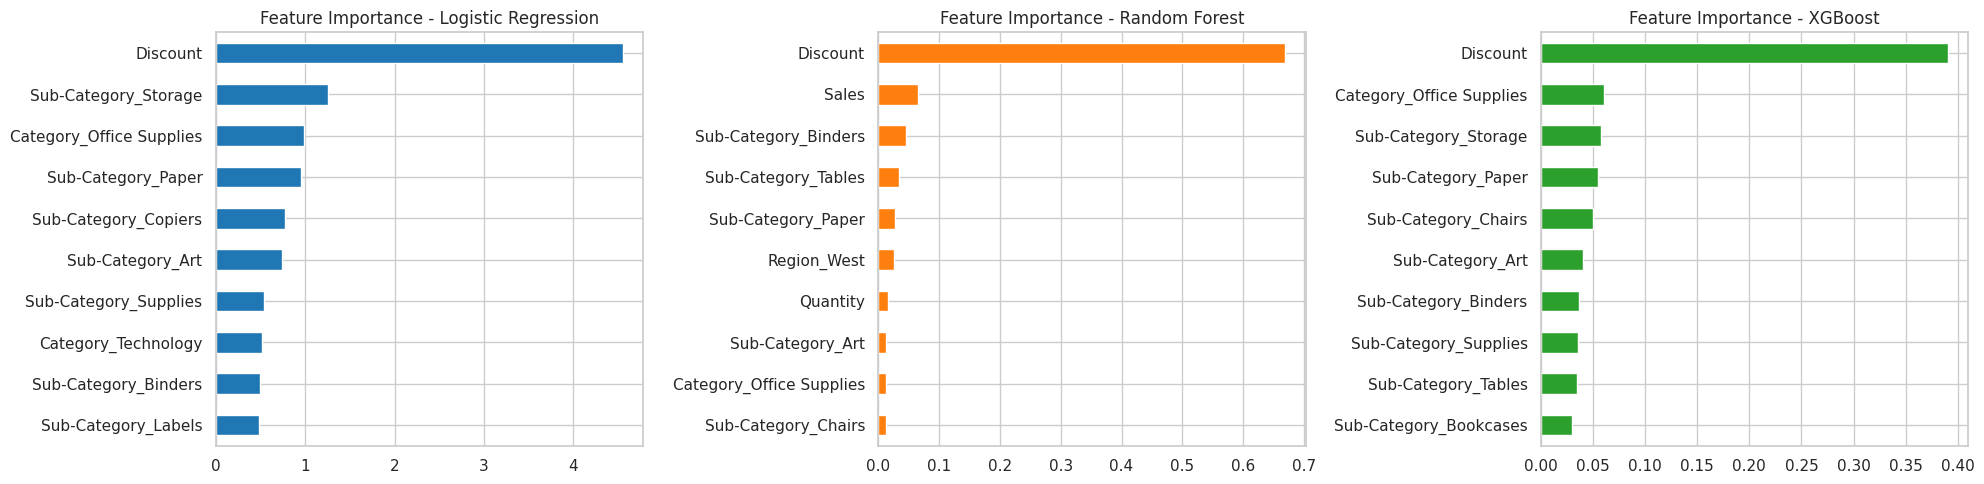

In [19]:
# Feature Importance
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Logistic Regression
lr_importance = pd.Series(np.abs(lr.coef_[0]), index=X_train.columns).sort_values(ascending=False)[:10]
lr_importance.plot(kind='barh', ax=axes[0], color='tab:blue', title='Feature Importance - Logistic Regression')
axes[0].invert_yaxis()

# Random Forest
rf_importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:10]
rf_importance.plot(kind='barh', ax=axes[1], color='tab:orange', title='Feature Importance - Random Forest')
axes[1].invert_yaxis()

# XGBoost
xgb_importance = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:10]
xgb_importance.plot(kind='barh', ax=axes[2], color='tab:green', title='Feature Importance - XGBoost')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

/tmp/ipython-input-3384528675.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


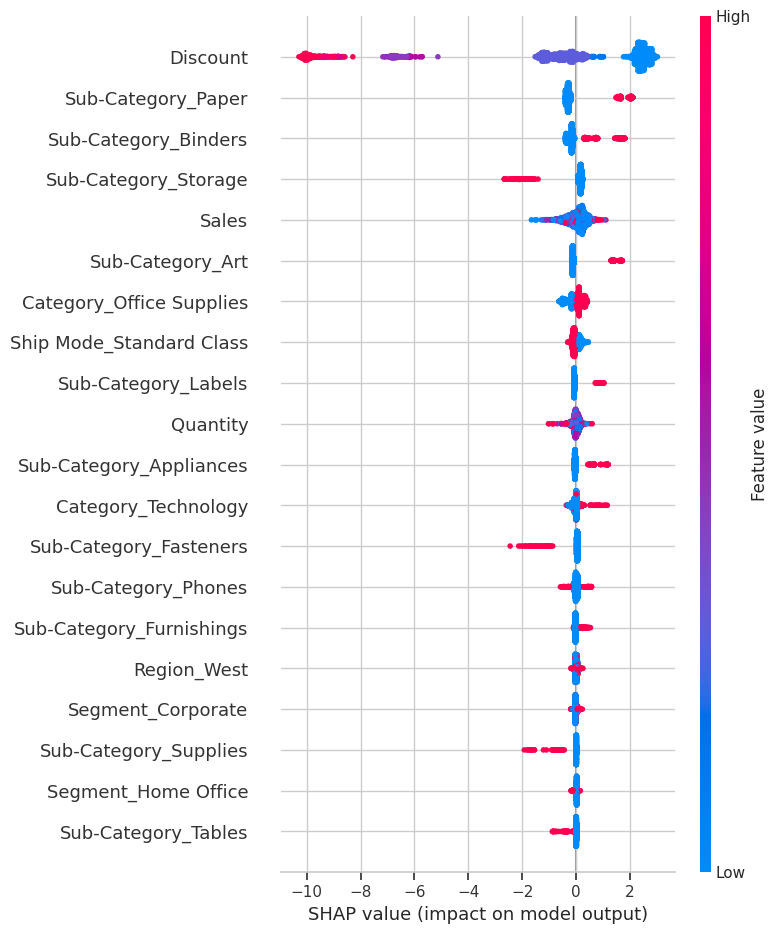

In [20]:
#SHAP Analysis (XGBoost)
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


--- Instance 1 ---


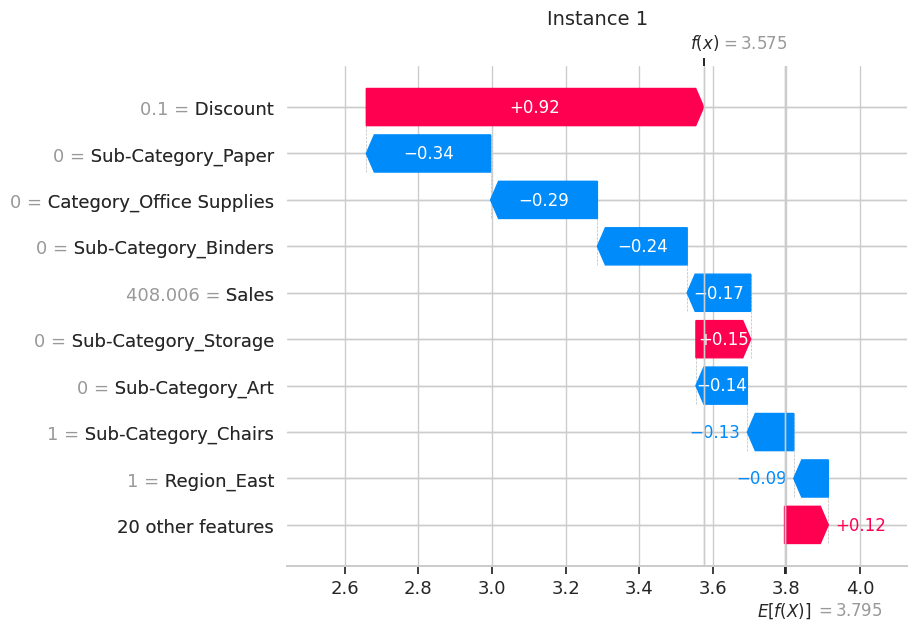


--- Instance 2 ---


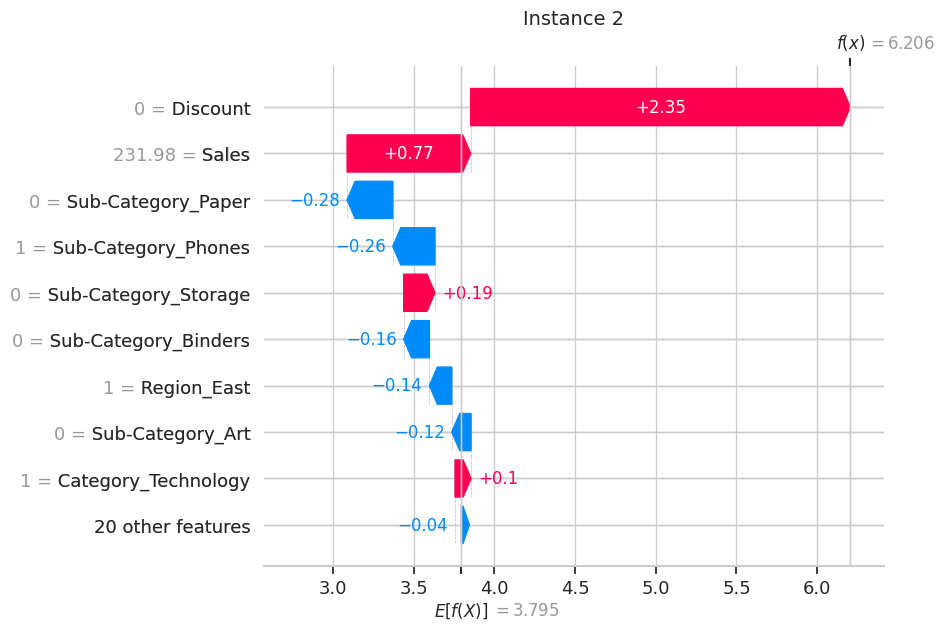


--- Instance 3 ---


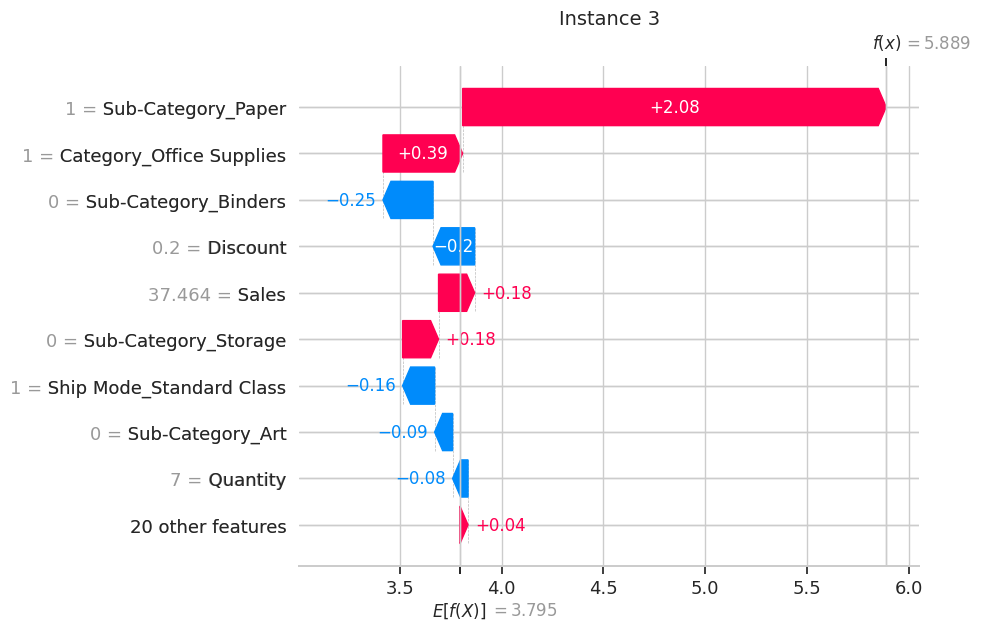

In [21]:
# SHAP Waterfall 3 instance
for i in range(3):
    print(f"\n--- Instance {i+1} ---")
    shap.plots.waterfall(shap_values[i], show=False)
    plt.title(f"Instance {i+1}", fontsize=14)
    plt.show()

In [22]:
#Error Analysis
error_df = X_test.copy()
error_df['Actual'] = y_test.values
error_df['Predicted'] = y_pred_xgb

error_df['Error_Type'] = np.where(
    (error_df['Actual']==1) & (error_df['Predicted']==0), 'False Negative',
    np.where(
        (error_df['Actual']==0) & (error_df['Predicted']==1), 'False Positive',
        'Correct'
    )
)

error_df['Error_Type'].value_counts()

,count
Error_Type,
Correct,1886
False Positive,83
False Negative,30


In [23]:
#Fairness Analysis
fairness_df = df.loc[X_test.index, ['Segment']]
fairness_df['Prediction'] = y_pred_xgb

pd.crosstab(
    fairness_df['Segment'],
    fairness_df['Prediction'],
    normalize='index'
)

Prediction,0,1
Segment,,
Consumer,0.166979,0.833021
Corporate,0.166951,0.833049
Home Office,0.167630,0.832370
